In [83]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
from matplotlib import pyplot as plt
import os
import cv2
import numpy as np
from math import log10
from torch.autograd import Variable
from skimage.util import random_noise
from skimage.color import rgb2gray
import h5py
import random
import glob
from matplotlib import pyplot as plt

In [90]:
class DnCNN(nn.Module):
    def __init__(self, channels = 1, num_of_layers=17):
        super(DnCNN, self).__init__()
        kernel_size = 3
        padding = 1
        features = 64
        layers = []
        layers.append(nn.Conv2d(in_channels=channels, out_channels=features, kernel_size=kernel_size, padding=padding, bias=False))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(num_of_layers-2):
            layers.append(nn.Conv2d(in_channels=features, out_channels=features, kernel_size=kernel_size, padding=padding, bias=False))
            layers.append(nn.BatchNorm2d(features))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(in_channels=features, out_channels=channels, kernel_size=kernel_size, padding=padding, bias=False))
        self.dncnn = nn.Sequential(*layers)
    def forward(self, x):
        out = self.dncnn(x)
        return out

In [85]:
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg", ".gif"])

In [86]:
class ImageDataset(Dataset):
  def __init__(self, image_dir, input_transforms=None):
      super(ImageDataset, self).__init__()
      self.image_filenames = [os.path.join(image_dir, x) for x in os.listdir(image_dir) ]
      self.input_transforms = input_transforms

  def __getitem__(self, index):
      input = Image.open(self.image_filenames[index])

      if self.input_transforms:
        input = self.input_transforms(input)
      
      return input
  
  def __len__(self):
      return len(self.image_filenames)

In [87]:
epochs = 50
lr = 1e-3

In [88]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# data directory
train_dir = '/content/drive/MyDrive/DnCNN_data/train'
test_dir =  '/content/drive/MyDrive/DnCNN_data/Set12'

In [91]:
# device


# crop size of images
crop_size = 128

# create train and test dataset
transform = transforms.Compose([
    # you can add other transformations in this list
    transforms.ToTensor()
])
train_dataset = ImageDataset(train_dir,input_transforms= transform)
test_dataset = ImageDataset(test_dir,input_transforms= transform)

# batch size
batch_size = 1

# create train and test dataloader
training_data_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)
testing_data_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)

# model declaration and hyperparameters
model = DnCNN().to(device)
criterion = nn.MSELoss()
lr = 1e-3
optimizer = optim.SGD(model.parameters(), lr=lr)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [92]:
# for i in range(400):
#   img = train_dataset.__getitem__(i).numpy()
#   img = rgb2gray(img)

train_dataset.__getitem__(2).numpy().shape

(1, 180, 180)

(180, 180)

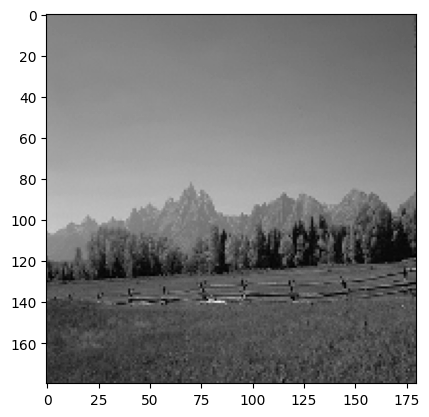

In [93]:
img  = plt.imread(train_dir +'/0001.png')
plt.imshow(img,cmap ='gray')
img.shape

In [94]:
def gaussian(ins, mean, stddev):  
    noise = Variable(ins.data.new(ins.size()).normal_(mean, stddev))
    return ins + noise, noise

In [95]:
def train(epoch):
    epoch_loss = 0
    for iteration, data in enumerate(training_data_loader,1):

        target = data
        input, noise = gaussian(target, 0, 0.1)
        
        if torch.cuda.is_available():
          input = Variable(input.cuda())
          noise = Variable(noise.cuda())
          target = Variable(target.cuda())
        
        output = model(input)

        loss = criterion(output, noise)
        epoch_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        

        # print("===> Epoch[{}]({}/{}): Loss: {:.4f}".format(epoch, iteration, len(training_data_loader), loss.item()))

    print("===> Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, epoch_loss / len(training_data_loader)))

In [98]:
def validate():
    avg_psnr = 0
    model.eval()
    with torch.no_grad():
        # for (iter,stack) in enumerate(testing_data_loader,1):
        for data in testing_data_loader:
            target = data
            input, noise = gaussian(target, 0, 0.05)

            if  torch.cuda.is_available():
              input = Variable(input.cuda())
              noise = Variable(noise.cuda())
              target = Variable(target.cuda())

            output = model(input)
            mse = criterion(output, input)
            psnr = 10 * log10(1 / mse.item())
            avg_psnr += psnr
    print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(testing_data_loader)))

In [99]:
def save_checkpoint(state):
    model_out_path = "model_epoch_{}.pth".format(epoch)
    torch.save(state, model_out_path)
    print("Checkpoint saved to {}".format(model_out_path))

In [100]:
num_epochs = 100
for epoch in range(1, num_epochs + 1):
    train(epoch)
    if epoch % 5 == 0:
      validate()
      save_checkpoint({
          'epoch': epoch + 1,
          'arch': model,
          'state_dict': model.state_dict(),
          'optimizer' : optimizer.state_dict(),
      })

===> Epoch 1 Complete: Avg. Loss: 0.0799
===> Epoch 2 Complete: Avg. Loss: 0.0417
===> Epoch 3 Complete: Avg. Loss: 0.0265
===> Epoch 4 Complete: Avg. Loss: 0.0198
===> Epoch 5 Complete: Avg. Loss: 0.0164
===> Avg. PSNR: 5.3001 dB
Checkpoint saved to model_epoch_5.pth
===> Epoch 6 Complete: Avg. Loss: 0.0159
===> Epoch 7 Complete: Avg. Loss: 0.0106
===> Epoch 8 Complete: Avg. Loss: 0.0102
===> Epoch 9 Complete: Avg. Loss: 0.0099
===> Epoch 10 Complete: Avg. Loss: 0.0096
===> Avg. PSNR: 5.5110 dB
Checkpoint saved to model_epoch_10.pth
===> Epoch 11 Complete: Avg. Loss: 0.0093
===> Epoch 12 Complete: Avg. Loss: 0.0090
===> Epoch 13 Complete: Avg. Loss: 0.0088
===> Epoch 14 Complete: Avg. Loss: 0.0085
===> Epoch 15 Complete: Avg. Loss: 0.0083
===> Avg. PSNR: 5.5120 dB
Checkpoint saved to model_epoch_15.pth
===> Epoch 16 Complete: Avg. Loss: 0.0081
===> Epoch 17 Complete: Avg. Loss: 0.0079
===> Epoch 18 Complete: Avg. Loss: 0.0077
===> Epoch 19 Complete: Avg. Loss: 0.0075
===> Epoch 20 Com

In [ ]:
# declare model
model = DnCNN().to(device)

# load checkpoint
model = torch.load('/content/model_epoch_50.pth')

# extract model architecture
model = model['arch']

# transformation on test image
loader = transforms.Compose([
        transforms.Resize((180,180)),
        transforms.ToTensor()])

# function to load image and convert to tensor
def image_loader(image_name):
    """load image, returns tensor"""
    image = Image.open(image_name)
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0) 
    return image.cuda()

# generate the clean image (i.e remove noise from image)
def remove_noise(model, image):
    out = torch.clamp(image-model(image), 0., 1.)
    out = out.cpu().clone()
    out = out.squeeze(0)
    trans = transforms.ToPILImage()
    # out = out.detach().numpy().astyp/e('uint8')
    # print(out.shape)
    plt.imshow(trans(out),cmap ='gray')
    trans(out).save('out.png')
    return trans(out)

In [ ]:
def display_tensor_img(img):
  img = img.cpu().clone()
  img = img.squeeze(0)
  trans = transforms.ToPILImage()
  # print(img)
  # img = (img*255).astype('uint8')
  plt.imshow(trans(img),cmap='gray')
  plt.show()

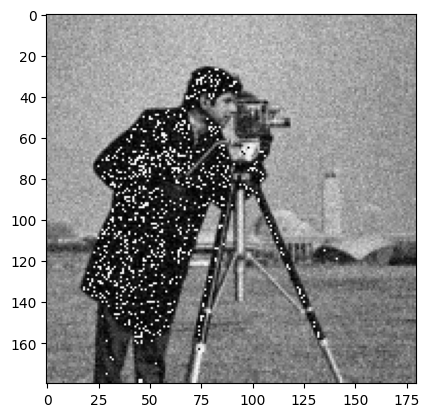

In [ ]:
display_tensor_img(noisy)

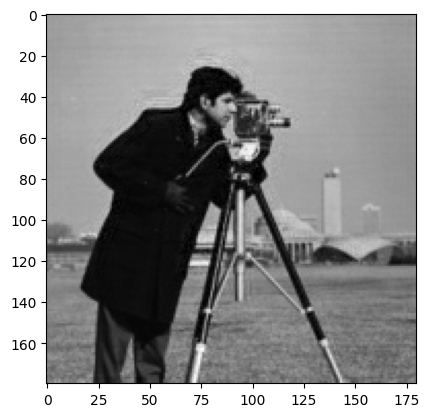

In [ ]:
img_path = test_dir+'/01.png'

# pass the image into the image_loader function
# plt.imshow(img_path,cmap = 'gray')
image = image_loader(img_path)
noisy, noise = gaussian(image, 0, 0.05)

# get prediction
output = remove_noise(model, image)
output.save('out.png')

In [ ]:
# img = plt.imread(img_path)
# noisy, noise = gaussian(img, 0, 0.05)

# plt.subplot(1,2,1)
# plt.imshow(img,cmap ='gray')
# plt.title('Original')
# plt.subplot(1,2,2)
# plt.imshow(noisy,cmap ='gray')
# plt.title('Noisy')
# plt.show()

AttributeError: ignored

In [ ]:
img.shape

(256, 256)